In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import dateparser


### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from scipy import stats as st
from cartopy import crs as ccrs

# dask 
from dask.diagnostics import ProgressBar

### plotting 
from matplotlib import pyplot as plt


In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 


In [4]:
import sys

In [5]:
sys.path.append('../../')

In [6]:
domain = [125, 240, -35, 25]

In [7]:
from ICU_Water_Watch import plot, geo, utils, GPM

### parameters for papermill

In [8]:
lag = 0
ndays = 30
# input path 
dpath = '/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP'
# output path 
opath = '/home/nicolasf/operational/ICU/development/hotspots/figures/GPM_IMERG'
# path to the shapefiles
dpath_shapes = '/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/'

In [9]:
# Parameters
ndays = 360
lag = 7


In [10]:
dpath = pathlib.Path(dpath)
opath = pathlib.Path(opath)

### climatology 

### get the list of files 

In [11]:
lfiles = GPM.get_files_list(dpath=dpath)

In [12]:
lfiles[0]

PosixPath('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2001.01.01.nc')

In [13]:
lfiles[-1]

PosixPath('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2022.01.05.nc')

### limit to the chosen day 

In [14]:
if lag != 0: 
    last_day = f"{lag} days ago"
    last_day = dateparser.parse(last_day)
    index = [x.name for x in lfiles].index(f"GPM_IMERG_daily.v06.{last_day:%Y.%m.%d}.nc")
    lfiles = lfiles[index+1-ndays:index+1]
else: 
    last_day = map(int, lfiles[-1].name.split(".")[-4:-1])
    last_day = datetime(*last_day)
    index = [x.name for x in lfiles].index(f"GPM_IMERG_daily.v06.{last_day:%Y.%m.%d}.nc")
    lfiles = lfiles[index+1-ndays:index+1]

In [15]:
if len(lfiles) != ndays: 
    print(f"problem with the number of files, expected {ndays}, got {len(lfiles)}")

### open the multiple file dataset and selects the variable of interest 

In [16]:
dset = GPM.make_dataset(lfiles=lfiles)

### calculates the accumulation 

### re-chunks first 

In [17]:
dset = dset.chunk({'time':-1, 'lon':10, 'lat':10})

In [18]:
dset = dset.sum('time', keep_attrs=True)

In [19]:
dset

<xarray.Dataset>
Dimensions:           (lat: 300, lon: 460)
Coordinates:
  * lon               (lon) float64 125.1 125.4 125.6 ... 239.4 239.6 239.9
  * lat               (lat) float64 -49.88 -49.62 -49.38 ... 24.38 24.62 24.88
Data variables:
    precipitationCal  (lat, lon) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
Attributes:
    BeginDate:       2021-01-06
    BeginTime:       00:00:00.000Z
    EndDate:         2021-01-06
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-01-06T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210106-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2021-01-07T14:50:33.490Z
    ndays:           360
    last_day:        2021-12-31

### Now reads the SPI climatology (alpha and beta parameters for each day of year for given accumulation period)

In [20]:
SPI_climatology = xr.open_dataset(dpath.joinpath(f"SPI_climatological_parameters_{ndays}_days.nc")) 

In [21]:
SPI_climatology

<xarray.Dataset>
Dimensions:  (lon: 460, lat: 300, doy: 366)
Coordinates:
  * lon      (lon) float64 125.1 125.4 125.6 125.9 ... 239.1 239.4 239.6 239.9
  * lat      (lat) float64 -49.88 -49.62 -49.38 -49.12 ... 24.38 24.62 24.88
Dimensions without coordinates: doy
Data variables:
    alpha    (doy, lat, lon) float64 ...
    beta     (doy, lat, lon) float64 ...

### selects the day of year corresponding to the last day 

In [22]:
SPI_climatology = SPI_climatology.sel(doy=last_day.timetuple().tm_yday)

In [23]:
norm_spi_realtime = GPM.calculate_SPI(dset['precipitationCal'], SPI_climatology['alpha'], SPI_climatology['beta']) 

In [24]:
norm_spi_realtime

<xarray.Dataset>
Dimensions:  (lon: 460, lat: 300)
Coordinates:
  * lon      (lon) float64 125.1 125.4 125.6 125.9 ... 239.1 239.4 239.6 239.9
  * lat      (lat) float64 -49.88 -49.62 -49.38 -49.12 ... 24.38 24.62 24.88
Data variables:
    SPI      (lat, lon) float64 0.6619 0.7445 0.5129 ... -0.3618 -0.276 -0.161

### adds global attributes for number of days and last day in the dataset 

In [25]:
norm_spi_realtime = GPM.set_attrs(norm_spi_realtime, ndays=ndays, last_day=last_day)

### reads in the EEZs 

In [26]:
from ICU_Water_Watch import geo

In [27]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes=dpath_shapes)

### reads in the coastlines 

In [28]:
coastlines = geo.get_coastlines(dpath_shapes=dpath_shapes)

### adds the EEZ mask to the dataset 

In [29]:
norm_spi_realtime = geo.make_mask_from_gpd(norm_spi_realtime, merged_EEZs, subset=True, mask_name='EEZ')

In [30]:
from ICU_Water_Watch.plot import * 

In [31]:
norm_spi_realtime.lon

<xarray.DataArray 'lon' (lon: 439)>
array([129.375, 129.625, 129.875, ..., 238.375, 238.625, 238.875])
Coordinates:
  * lon      (lon) float64 129.4 129.6 129.9 130.1 ... 238.1 238.4 238.6 238.9

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_s

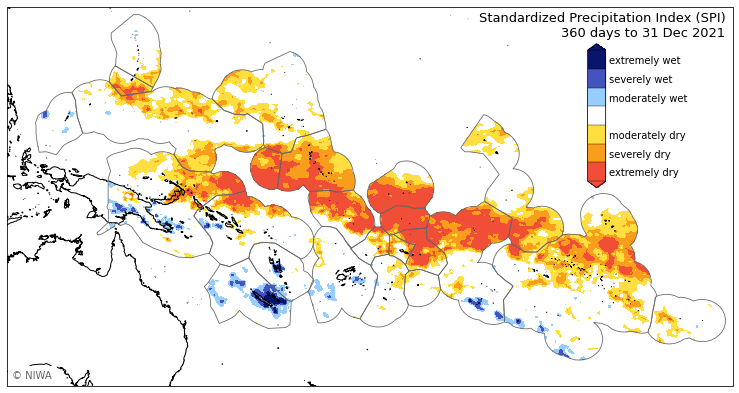

In [32]:
map_SPI_Pacific(norm_spi_realtime, mask='EEZ', geoms=EEZs, fpath=opath, close=False)

### Now produce a country level SPI 

In [33]:
if not(opath.joinpath('SPI')).exists(): 
    (opath.joinpath('SPI')).mkdir(parents=True)

In [34]:
for country_name in coastlines.country_na: 
    
    print(f"{utils.sanitize_name(country_name)}")
    
    cpath = pathlib.Path(f'/home/nicolasf/operational/ICU/development/hotspots/figures/GPM_IMERG/SPI')
    
    # cpath = pathlib.Path(f'/home/nicolasf/operational/ICU_Web/GPM_IMERG/SPI/{utils.sanitize_name(country_name)}')
    
    if not cpath.exists(): 
        
        cpath.mkdir(parents=True)
    
    print(f"   --> processing {country_name} for the SPI\n")

    coastline = coastlines.query(f"country_na == '{country_name}'")

    EEZ = EEZs.query(f"COUNTRYNAM == '{country_name}'")
    
    dset_sub_country = geo.make_mask_from_gpd(norm_spi_realtime, EEZ, subset=True, mask_name='mask_EEZ')
    
    map_SPI(dset_sub_country, coastlines, coastline, EEZ, country_name=country_name, fpath=cpath, close=True)

American_Samoa
   --> processing American Samoa for the SPI



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


Cook_Islands
   --> processing Cook Islands for the SPI



Federated_States_of_Micronesia
   --> processing Federated States of Micronesia for the SPI



Fiji
   --> processing Fiji for the SPI



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:848: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/numpy/lib/function_base.py:4739: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = asanyarray(arr)
/home/nicolasf/mambaforge/envs/cl

French_Polynesia
   --> processing French Polynesia for the SPI



Guam
   --> processing Guam for the SPI



Kiribati_Gilbert_Islands
   --> processing Kiribati: Gilbert Islands for the SPI



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:848: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/numpy/lib/function_base.py:4739: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = asanyarray(arr)
/home/nicolasf/mambaforge/envs/cl

Kiribati_Line_Islands
   --> processing Kiribati: Line Islands for the SPI



Kiribati_Phoenix_Islands
   --> processing Kiribati: Phoenix Islands for the SPI



Marshall_Islands
   --> processing Marshall Islands for the SPI



Nauru
   --> processing Nauru for the SPI



New_Caledonia
   --> processing New Caledonia for the SPI



Niue
   --> processing Niue for the SPI



Northern_Marianas
   --> processing Northern Marianas for the SPI



Palau
   --> processing Palau for the SPI



Papua_New_Guinea
   --> processing Papua New Guinea for the SPI



Pitcairn_Islands
   --> processing Pitcairn Islands for the SPI



Samoa
   --> processing Samoa for the SPI



Solomon_Islands
   --> processing Solomon Islands for the SPI



Tokelau
   --> processing Tokelau for the SPI



Tonga
   --> processing Tonga for the SPI



Tuvalu
   --> processing Tuvalu for the SPI



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:848: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/numpy/lib/function_base.py:4739: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = asanyarray(arr)
/home/nicolasf/mambaforge/envs/cl

Vanuatu
   --> processing Vanuatu for the SPI



Wallis_Futuna
   --> processing Wallis & Futuna for the SPI



/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/nicolasf/mambaforge/envs

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:853: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
